In [100]:
import pandas as pd
import os
import sys
import metrics
import model_pipeline
import utils
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import joblib

# read and prep data

In [101]:
X,y  = utils.prep_playlist_df()

In [102]:
X_train, X_test,y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.35, 
                                                   random_state=0, 
                                                   stratify  = y, 
                                                   shuffle = True)

In [103]:
print(X_train.shape, X_test.shape)

(1571, 15) (846, 15)


#  Random forest Pipeline

In [6]:
pipeline = model_pipeline.make_random_forest_pipeline(X)

In [7]:
pipeline

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['artist_names',
                                                   'track_names'])])),
                ('sampler', RandomOverSampler()),
                ('classifier', RandomForestClassifier())])

In [8]:
model = pipeline.fit(X_train, y_train)

In [9]:
model.score(X_test, y_test)

0.36524822695035464

In [23]:
y_pred = model.predict(X_test)

In [24]:
print(f"f1: {metrics.f1(y_test, y_pred):.3f}")

f1: 0.300


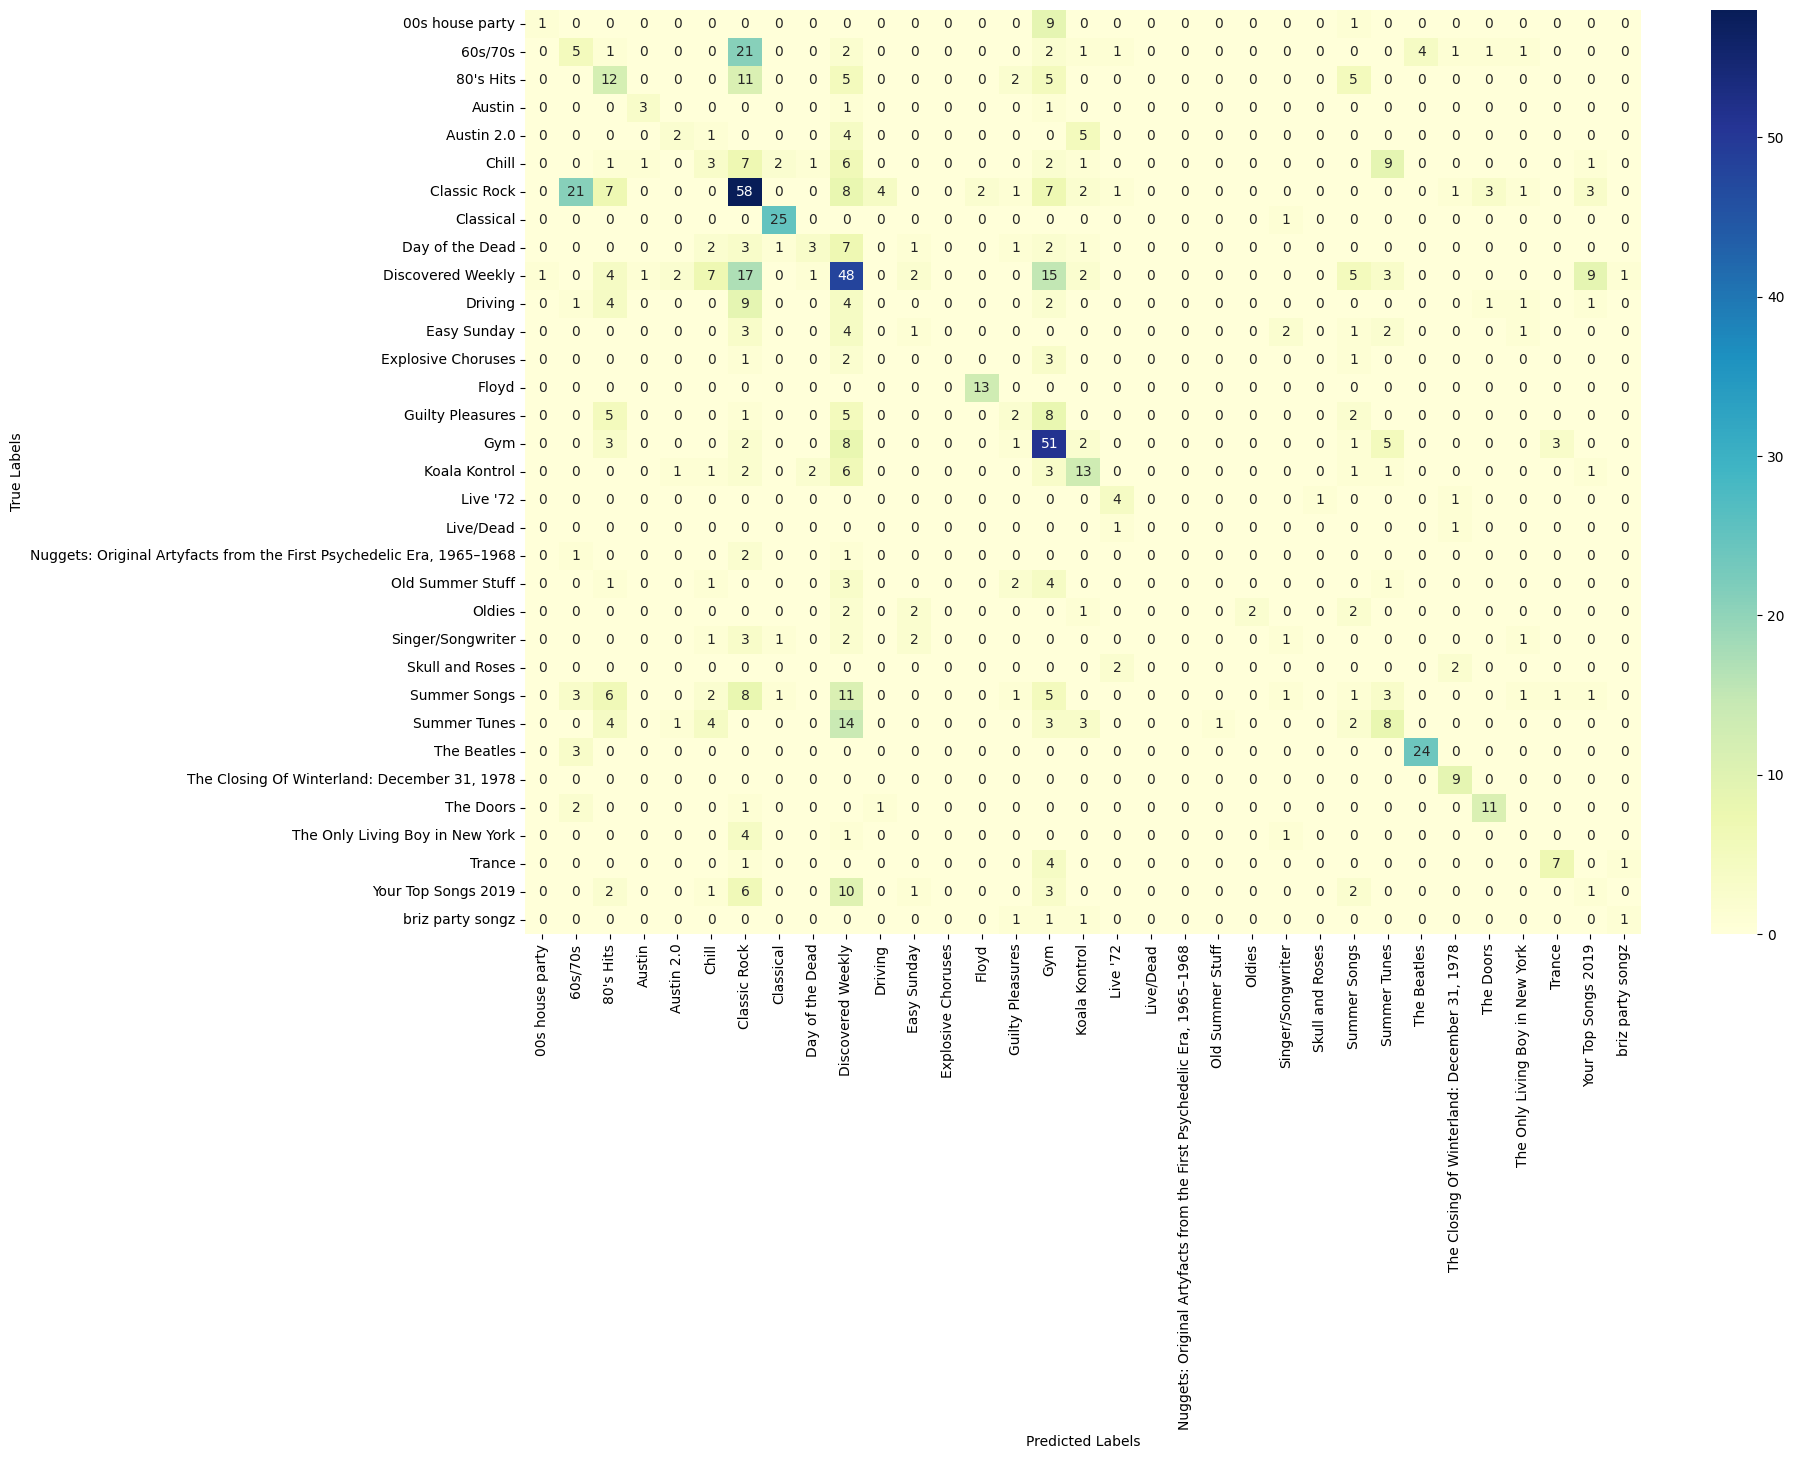

In [25]:
metrics.confusion_matrix(y_test, y_pred)

# Classifier comparison

First I'm comparing a few algorithms to see which perform best with some basic hyperparameter tuning, then I'll take the best models for further refinement. 


In [78]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [79]:
y_train  = le.transform(y_train)
y_test  = le.transform(y_test)

In [80]:
pipeline = model_pipeline.make_model_pipeline(X)

In [81]:
pipeline

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness', 'mode',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['artist_names',
                                                   'track_names'])])),
                ('sampler', RandomOverSampler()), ('clf', ClfSwitcher())])

In [88]:
parameters = [
        {
        'clf__estimator': [LogisticRegression(max_iter = 1000)], 
        'clf__estimator__C' : [10, 1.0, 0.1, 0.01]
    },
    {
        'clf__estimator': [xgb.XGBClassifier()], 
        'clf__estimator__max_depth': [6,10],
        'clf__estimator__learning_rate': [0.1, 0.05]
    },   
    {
        'clf__estimator': [MLPClassifier()], 
        'clf__estimator__hidden_layer_sizes':[(50,50,50), (50,100,50)],
        'clf__estimator__alpha': [0.0001],
        'clf__estimator__learning_rate': ['adaptive'],
    }, 
    ]

In [90]:
gscv = GridSearchCV(pipeline, 
                    parameters, 
                    scoring = 'f1_micro', 
                    cv=4,
                    return_train_score=False, 
                    verbose=3, 
                    refit = True)
gscv.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END clf__estimator=LogisticRegression(max_iter=1000), clf__estimator__C=10;, score=0.277 total time=  11.6s
[CV 2/4] END clf__estimator=LogisticRegression(max_iter=1000), clf__estimator__C=10;, score=0.338 total time=   7.5s
[CV 3/4] END clf__estimator=LogisticRegression(max_iter=1000), clf__estimator__C=10;, score=0.340 total time=   6.5s
[CV 4/4] END clf__estimator=LogisticRegression(max_iter=1000), clf__estimator__C=10;, score=0.303 total time=   6.6s
[CV 1/4] END clf__estimator=LogisticRegression(max_iter=1000), clf__estimator__C=1.0;, score=0.273 total time=   3.7s
[CV 2/4] END clf__estimator=LogisticRegression(max_iter=1000), clf__estimator__C=1.0;, score=0.346 total time=   3.2s
[CV 3/4] END clf__estimator=LogisticRegression(max_iter=1000), clf__estimator__C=1.0;, score=0.320 total time=   3.3s
[CV 4/4] END clf__estimator=LogisticRegression(max_iter=1000), clf__estimator__C=1.0;, score=0.337 total time=   2.8s

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('features',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['danceability',
                                                                          'energy',
                                                                          'key',
                                                                          'loudness',
                                                                          'mode',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                                                          'valence',
                                                                          'tempo',
                                                                          'duration_ms',
                                                                          'time_signature']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['artist_names',
                                                                          'track_names'])])...
                                                           predictor=None,
                                                           random_state=None,
                                                           reg_alpha=None,
                                                           reg_lambda=None, ...)],
                          'clf__estimator__learning_rate': [0.1, 0.05],
                          'clf__estimator__max_depth': [6, 10]},
                         {'clf__estimator': [MLPClassifier()],
                          'clf__estimator__alpha': [0.0001],
                          'clf__estimator__hidden_layer_sizes': [(50, 50, 50),
                                                                 (50, 100, 50)],
                          'clf__estimator__learning_rate': ['adaptive']}],
             scoring='f1_macro', verbose=3)

In [91]:
gscv.best_params_

{'clf__estimator': LogisticRegression(max_iter=1000), 'clf__estimator__C': 1.0}

In [95]:
joblib.dump(gscv.best_estimator_, 'classifier_model.pkl')

['classifier_model.pkl']

In [92]:
print(f"best f1: {gscv.best_score_:.3f}")

best f1: 0.319


In [93]:
y_pred = gscv.predict(X_test)

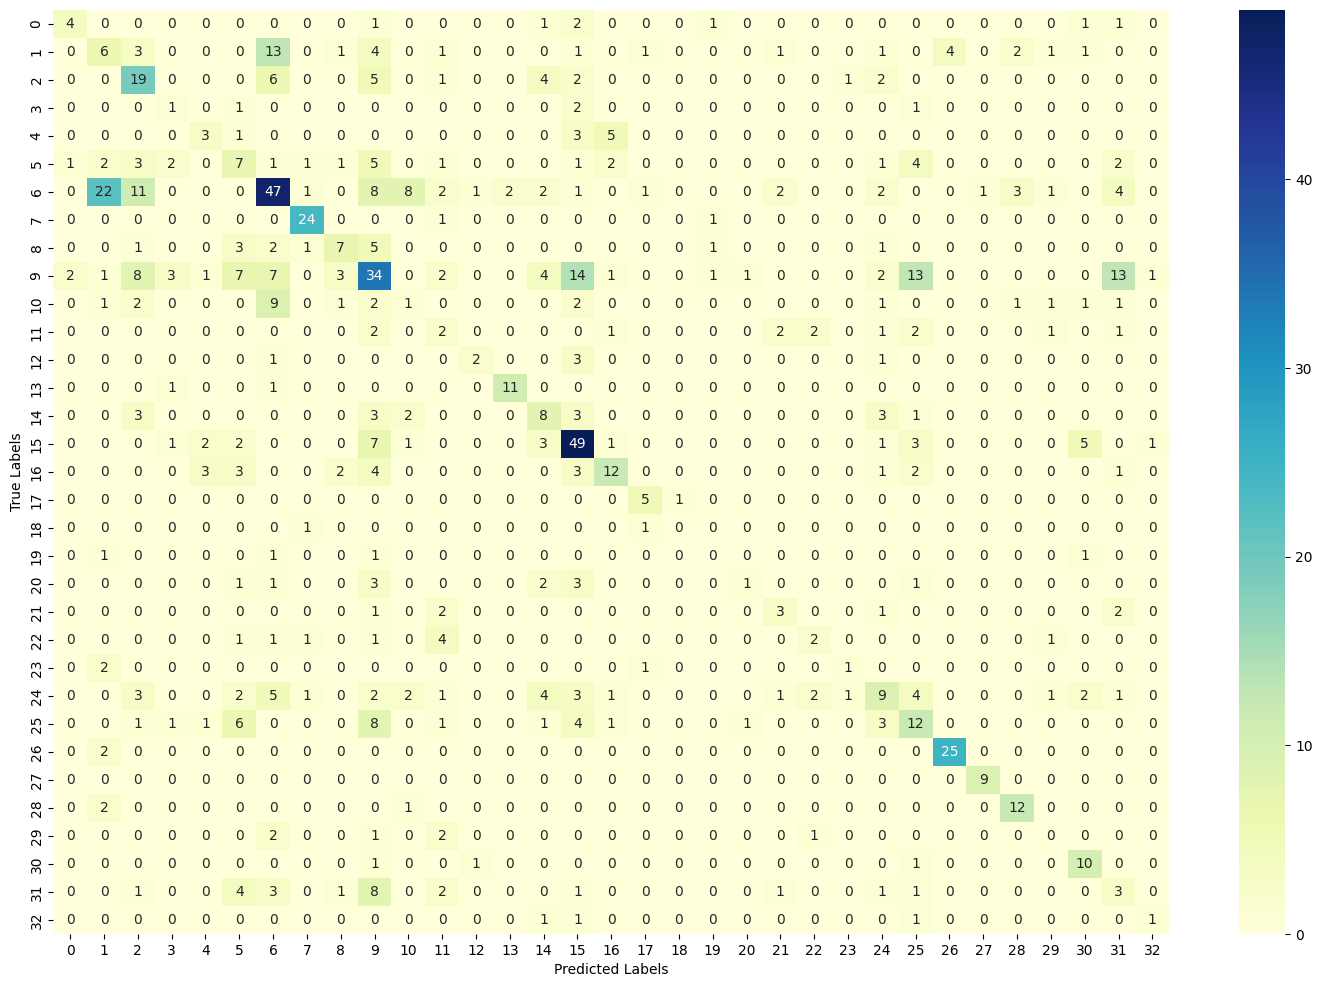

In [94]:
metrics.confusion_matrix(y_test, y_pred)

In [1]:
utils.invert_label_encoding(le)

NameError: name 'utils' is not defined